In [109]:
%matplotlib widget
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import interpolate
import airglow_response as ar

In [2]:
file_atmos = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/data/profile_VCD_for_scaling_pd.csv'
profile = pd.read_csv(file_atmos)
f_rho = interpolate.interp1d(profile.altitude/1e3, profile.rho, kind='quadratic')
f_t = interpolate.interp1d(profile.altitude/1e3, profile.t, kind='quadratic')
f_gamma = interpolate.interp1d(profile.altitude/1e3, profile.gamma, kind='quadratic')
f_c = interpolate.interp1d(profile.altitude/1e3, profile.c, kind='quadratic')

In [121]:
folder_data='./Venus_Detectability/data/'

file_airglow = f'{folder_data}VER_profile_scaled.csv'
VER = pd.read_csv(file_airglow)
VER.columns=['VER', 'alt']
f_VER = interpolate.interp1d(VER.alt, VER.VER, kind='quadratic', bounds_error=False, fill_value=0.)

file_airglow = f'{folder_data}VER_profile_dayglow.csv'
VER = pd.read_csv(file_airglow)
VER.columns=['VER', 'alt']
VER.to_csv(file_airglow.replace('.csv', '_scaled.csv'), index=False)
f_VER_dayglow = interpolate.interp1d(VER.alt, VER.VER, kind='cubic', bounds_error=False, fill_value=0.)

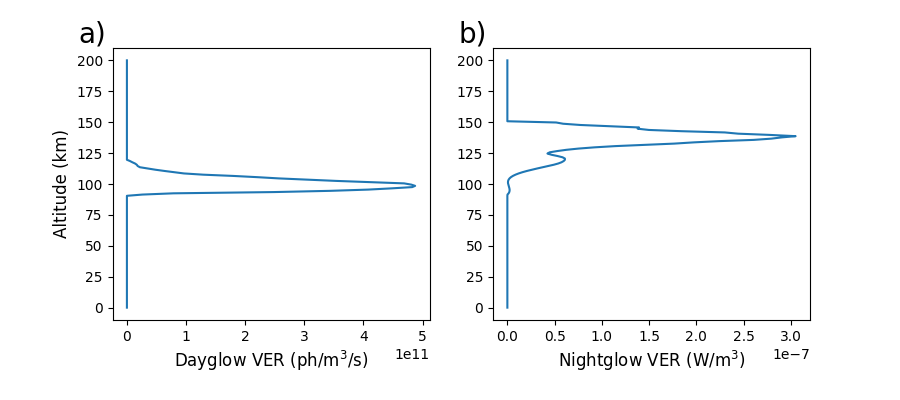

In [132]:
import string

alphabet = string.ascii_lowercase

alts_dayglow = np.linspace(0., 200., 200)
fontsize = 12.

fig = plt.figure(figsize=(9,4))
grid = fig.add_gridspec(1, 2)

ax = fig.add_subplot(grid[0, 0], )
ax.plot(f_VER(alts_dayglow), alts_dayglow)
ax.set_ylabel('Altitude (km)', fontsize=fontsize)
ax.set_xlabel('Dayglow VER (ph/m$^3$/s)', fontsize=fontsize)
ax.text(-0.02, 1.1, f'{alphabet[0]})', fontsize=20., ha='right', va='top', transform=ax.transAxes)

ax = fig.add_subplot(grid[0, 1], )
ax.plot(f_VER_dayglow(alts_dayglow), alts_dayglow)
ax.set_xlabel('Nightglow VER (W/m$^3$)', fontsize=fontsize)
ax.text(-0.02, 1.1, f'{alphabet[1]})', fontsize=20., ha='right', va='top', transform=ax.transAxes)
              
fig.subplots_adjust(bottom=0.2)
fig.savefig('./figures/VER_profiles.pdf')

In [108]:
models = ['Cold_100', 'Hot_25', 'Hot_10']
seismic_models = pd.DataFrame()
for model in models:
    file = f'./data/{model}_for_QSSP.csv'
    loc_model = pd.read_csv(file, header=None, delim_whitespace=True, names=['z', 'vp', 'vs', 'rho', 'Qp', 'Qs'])
    loc_model['model'] = model
    seismic_models = pd.concat([seismic_models, loc_model])
seismic_models.reset_index(drop=True, inplace=True)

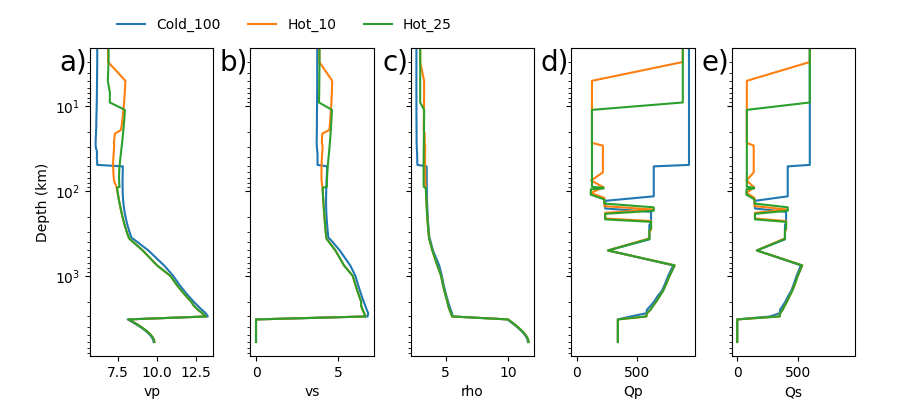

In [133]:
import string

alphabet = string.ascii_lowercase

fig = plt.figure(figsize=(9,4))
grid = fig.add_gridspec(1, 5)

unknowns = ['vp', 'vs', 'rho', 'Qp', 'Qs']
for ii, unknown in enumerate(unknowns):
    data_loc = seismic_models
    
    share_opt = dict()
    if ii == len(unknowns)-1:
        share_opt = dict(sharex=ax)
    ax = fig.add_subplot(grid[0, ii], **share_opt)
    ax.text(-0.02, 1.0, f'{alphabet[ii]})', fontsize=20., ha='right', va='top', transform=ax.transAxes)
    
    for model, data_loc_model in data_loc.groupby('model'):
        
        label = dict()
        if ii == 0:
            label['label'] = model
        
        if unknown != 'Q':
            ax.plot(data_loc_model[unknown], data_loc_model.z, **label)
        else:
            ax.plot(data_loc_model['Qp'], data_loc_model.z)
        
    ax.set_yscale('log')
        
    if ii > 0:
        ax.tick_params(axis='both', which='both', labelleft=False)
    else:
        ax.set_ylabel(f'Depth (km)')
        
    ax.set_xlabel(f'{unknown}')
    ax.invert_yaxis()
    if ii == 0:
        ax.legend(frameon=True, facecolor='white', framealpha=0.8, edgecolor='none', ncol=3, bbox_to_anchor=(0.12, 1.14), bbox_transform=ax.transAxes)
        
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.3)
fig.savefig('./figures/seismic_profiles.pdf')

In [13]:
def get_amplification_spectrum_kenda(alts_dayglow, freq_targets, deactivate_bar=True):
    atten = pd.read_csv('./data/attenuation_kenda.csv', header=[0])
    alts = atten.alt.unique()
    freq = atten.frequency.unique()
    FF, AA = np.meshgrid(freq, alts)

    alpha = atten.alpha.values.reshape((alts.size, freq.size))
    alpha = interpolate.interp1d(freq, alpha, axis=1, bounds_error=False, fill_value=0.0)
    amplification = atten.amplification.values.reshape((alts.size, freq.size))
    amplification = interpolate.interp1d(freq, amplification, kind='quadratic', axis=1, bounds_error=False, fill_value=0.0)

    dz = alts[1] - alts[0]
    amplification_output = np.ones((freq_targets.size, alts_dayglow.size))
    attenuation_output = np.ones((freq_targets.size, alts_dayglow.size))
    for ifreq, freq_target in enumerate(freq_targets):
        amp_loc = amplification(freq_target)*np.exp(-dz*np.cumsum(alpha(freq_target), ))
        atten_loc = np.cumsum(alpha(freq_target), )
        attenuation_output[ifreq,:] = interpolate.interp1d(alts, atten_loc, kind='quadratic', bounds_error=False, fill_value=(atten_loc[0], atten_loc[-1]))(alts_dayglow)
        amplification_output[ifreq,:] = interpolate.interp1d(alts, amp_loc, kind='quadratic', bounds_error=False, fill_value=(amp_loc[0], amp_loc[-1]))(alts_dayglow)

    return amplification_output, attenuation_output

alts_dayglow = np.linspace(0., 200., 200)
freq_targets = np.logspace(-2, 0, 50)
amplification_output, attenuation_output = get_amplification_spectrum_kenda(alts_dayglow, freq_targets,)

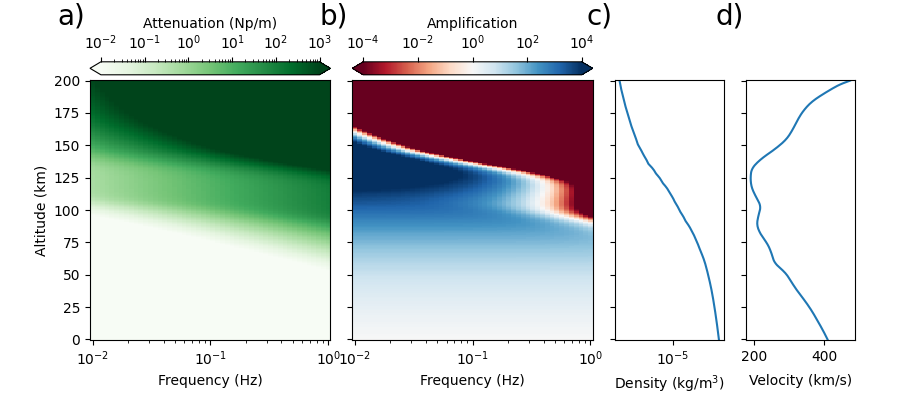

In [134]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import string

alphabet = string.ascii_lowercase

axs = []
fig = plt.figure(figsize=(9,4))
grid = fig.add_gridspec(1, 6)

ax = fig.add_subplot(grid[0, :2])
sc = ax.pcolormesh(freq_targets, alts_dayglow, attenuation_output.T, norm=LogNorm(vmin=1e-2, vmax=1e3), shading='auto', cmap='Greens')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Altitude (km)')
ax.set_xscale('log')
ax.text(-0.02, 1.3, f'{alphabet[0]})', fontsize=20., ha='right', va='top', transform=ax.transAxes)
axs.append(ax)

ax_cbar = inset_axes(ax, width="100%", height="5%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
ax_cbar.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
cbar = plt.colorbar(sc, cax=ax_cbar, extend='both', orientation='horizontal')
cbar.ax.set_xlabel('Attenuation (Np/m)',)
cbar.ax.tick_params(axis='both', which='both', labelbottom=False, bottom=False, labeltop=True, top=True)
cbar.ax.xaxis.set_label_position('top')

amplification_output_d = amplification_output[:]
amplification_output_d[amplification_output_d<1e-4] = 1e-4
ax = fig.add_subplot(grid[0, 2:4], sharex=ax, sharey=ax)
sc = ax.pcolormesh(freq_targets, alts_dayglow, amplification_output_d.T, norm=LogNorm(vmin=1e-4, vmax=1e4), shading='auto', cmap='RdBu')
ax.set_xlabel('Frequency (Hz)')
ax.text(-0.02, 1.3, f'{alphabet[1]})', fontsize=20., ha='right', va='top', transform=ax.transAxes)
axs.append(ax)

ax_cbar = inset_axes(ax, width="100%", height="5%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
ax_cbar.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
cbar = plt.colorbar(sc, cax=ax_cbar, extend='both', orientation='horizontal')
cbar.ax.set_xlabel('Amplification',)
cbar.ax.tick_params(axis='both', which='both', labelbottom=False, bottom=False, labeltop=True, top=True)
cbar.ax.xaxis.set_label_position('top')
ax.tick_params(axis='both', which='both', labelleft=False)

ax = fig.add_subplot(grid[0, 4], sharey=ax)
ax.plot(f_rho(alts_dayglow), alts_dayglow)
ax.set_xscale('log')
ax.tick_params(axis='both', which='both', labelleft=False)
ax.set_xlabel('Density (kg/m$^3$)')
axs.append(ax)
ax.text(-0.02, 1.3, f'{alphabet[2]})', fontsize=20., ha='right', va='top', transform=ax.transAxes)

ax = fig.add_subplot(grid[0, 5], sharey=ax)
ax.plot(f_c(alts_dayglow), alts_dayglow)
ax.tick_params(axis='both', which='both', labelleft=False)
ax.set_xlabel('Velocity (km/s)')
axs.append(ax)
ax.text(-0.02, 1.3, f'{alphabet[3]})', fontsize=20., ha='right', va='top', transform=ax.transAxes)

fig.subplots_adjust(left=0.1, bottom=0.15, top=0.8, right=0.95)
fig.align_xlabels(axs)
fig.align_ylabels(axs)
fig.savefig('./figures/atmos_profiles.pdf')